In [2]:
#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from datasets import load_dataset
from torch import optim
from torch import nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.models as models

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import json


c:\Users\evand\OneDrive\ECE 556\ECE556-Final-Project\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Hyperparameters
input_size = 128*128
learning_rate = 0.0001
num_epochs = 10
batch_size = 64

In [4]:
#load datasets
ds = load_dataset("Scuccorese/food-ingredients-dataset", split="train[:2000]") #2000 images pulled 
ingredients = sorted(set(ds["ingredient"]))
ds = ds.train_test_split(test_size=0.2) #split data into training data and validation data
print(ds["train"][0])

{'category': 'vegetables', 'subcategory': 'cruciferous', 'ingredient': 'broccoli', 'image': <PIL.WebPImagePlugin.WebPImageFile image mode=RGB size=800x534 at 0x25A30BC9810>}


In [5]:
#create dictionary that maps label name to integer
label2id = {name: str(i) for i, name in enumerate(ingredients)}
id2label = {str(i): name for i, name in enumerate(ingredients)}

#save id2label
with open("JSON/id2label.json", "w") as f:
    json.dump(id2label, f)

num_classes = len(ingredients)
print("Number of Classes:", num_classes)

print(id2label["0"])

Number of Classes: 100
adzuki beans


In [6]:
#process image into tensor
transform = transforms.Compose([
    transforms.Resize((128,128)),          # Resize images to 128x128 (this number can be changed for different resolutions)
    transforms.ToTensor(),                 # Convert PIL image to tensor
])

def transform_fn(data):
    image = data["image"].convert("RGB") #make all images RGB to avoid initial channel mismatches
    data["image"] = transform(image)
    data["label"] = int(label2id[data["ingredient"]])
    return data

ds["train"] = ds["train"].map(transform_fn)
ds["test"]  = ds["test"].map(transform_fn)

#convert to pytorch tensor
ds["train"] = ds["train"].with_format("torch", columns=["image", "label"])
ds["test"] = ds["test"].with_format("torch", columns=["image", "label"])

#compute mean and std for normalization
all_images = torch.stack([img for img in ds["train"]["image"]], dim=0)
mean, std = all_images.mean(dim=[0, 2, 3]), all_images.std(dim=[0, 2, 3])
print("mean: ", mean, "standard deviation: ", std)

#save mean and std before normalization
norm_stats = {
    "mean": mean.tolist(),
    "std": std.tolist()
}

with open("JSON/norm_stats.json", "w") as f:
    json.dump(norm_stats, f)

#normalize dataset
transform_norm = transforms.Compose([
    transforms.Normalize(mean, std)
])

def transform_norm_fn(data):
    data["image"] = transform_norm(data["image"])
    return data

ds["train"] = ds["train"].map(transform_norm_fn)
ds["test"] = ds["test"].map(transform_norm_fn)

#create dataloaders
train_loader = DataLoader(dataset=ds["train"], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=ds["test"], batch_size=batch_size, shuffle=False)

Map: 100%|██████████| 400/400 [00:40<00:00,  9.88 examples/s]


mean:  tensor([0.6107, 0.5750, 0.4676]) standard deviation:  tensor([0.2956, 0.2860, 0.3241])


Map: 100%|██████████| 400/400 [00:08<00:00, 47.43 examples/s]


C:\Users\Pu441\AppData\Local\Temp\ipykernel_34892\4213850470.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = std * img + mean            # unnormalize


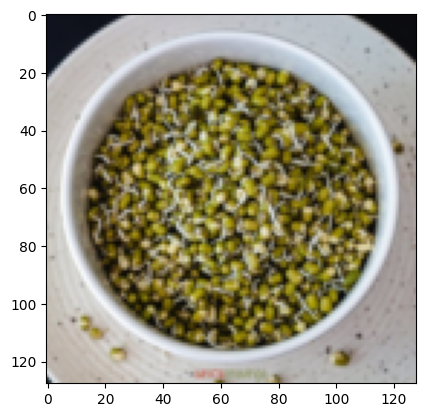

Ingredient:  sprouted lentils


In [6]:
# Display image and label
image_idx = 6
img = ds["train"]["image"][image_idx].numpy()
img = np.transpose(img, (1,2,0))  # C,H,W -> H,W,C
img = std * img + mean            # unnormalize
img = np.clip(img, 0, 1)          # clip to valid range
plt.imshow(img)
plt.show()

print("Ingredient: ", id2label[str(int(ds["train"]["label"][image_idx]))])

In [19]:
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:


patience = 3  # Number of epochs to wait for improvement before stopping
best_loss = float('inf')  # Start with very large loss so first epoch always improves
epochs_without_improvement = 0  # Counter for consecutive non-improving epochs




for epoch in range(num_epochs):

    model.train()  # Set model to training mode (enables dropout, batchnorm updates)

    running_loss = 0.0  # Accumulate loss over the epoch
    correct = 0         # Count correct predictions
    total = 0           # Count total samples processed

    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    for batch in train_loader:

        # Move data to GPU (if available)
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        # Forward pass: compute predictions
        outputs = model(images)

        # Compute loss between predictions and true labels
        loss = criterion(outputs, labels)

        # Clear previous gradients (PyTorch accumulates gradients by default)
        optimizer.zero_grad()

        # Backward pass: compute gradients
        loss.backward()

        # Update model weights
        optimizer.step()

        # Add this batch's loss to running total
        running_loss += loss.item()

        # Get predicted class (index of max logit)
        _, predicted = torch.max(outputs, 1)

        # Update total sample count
        total += labels.size(0)

        # Count correct predictions
        correct += (predicted == labels).sum().item()


    # Compute average loss for the epoch
    epoch_loss = running_loss / len(train_loader)

    # Compute accuracy percentage
    epoch_acc = 100 * correct / total

    print(f'Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%')


    # If loss improved, reset counter
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_without_improvement = 0
    else:
        # If loss did not improve, increment counter
        epochs_without_improvement += 1

    # If model has not improved for 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break


print("Finished Training")

Epoch [1/10]
Loss: 4.3886 | Accuracy: 8.69%
Epoch [2/10]
Loss: 2.5950 | Accuracy: 60.38%
Epoch [3/10]
Loss: 1.6796 | Accuracy: 83.56%
Epoch [4/10]
Loss: 1.0589 | Accuracy: 90.44%
Epoch [5/10]
Loss: 0.6851 | Accuracy: 93.00%
Epoch [6/10]
Loss: 0.4478 | Accuracy: 94.25%
Epoch [7/10]
Loss: 0.3143 | Accuracy: 94.75%
Epoch [8/10]
Loss: 0.2385 | Accuracy: 94.56%
Epoch [9/10]
Loss: 0.1996 | Accuracy: 95.06%
Epoch [10/10]
Loss: 0.1817 | Accuracy: 94.56%
Finished Training


In [21]:
#Save trained model
PATH = './food_net.pth'
torch.save(model.state_dict(), PATH)

In [22]:
#Find the accuracy of the network on the validation dataset
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for data in val_loader:
        images = data["image"].to(device)
        labels = data["label"].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 44.0 %
